In [58]:
import os
import re
from pathlib import Path
import datetime

# essentials
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# tensorflow tools
import scipy
import keras
from keras.applications.resnet import ResNet50, ResNet152, preprocess_input as resnet_preprocess
from keras.preprocessing import image
from keras import Model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import load_model

# prunning
import tensorflow_model_optimization as tfmot

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Loading data

In [2]:
root_dir = "./"

In [16]:
# Filepaths to training and test sets
base_dir = os.path.join(root_dir, 'fruits-360_dataset/fruits-360')

train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')

In [13]:
# Getting a list of labels
label_list = os.listdir(train_dir)

In [25]:
# Fixed parameters
batch_size = 32
num_classes = len(label_list)
image_size = (224, 224, 3)
n_epochs = 4

In [10]:
# Creating data generators for training and test sets
train_datagen = image.ImageDataGenerator(
    validation_split=0.2,
    # data augmentation parameters
    # Rules were followed:
    # no color change
    # being careful with shape modifications
    # focused on rotations and flips
    rotation_range=180,
    shear_range=10,
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = image.ImageDataGenerator()

In [17]:
train_gen = train_datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    target_size=image_size[:-1]
)

validation_gen = train_datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    target_size=image_size[:-1]
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    target_size=image_size[:-1]
)

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


# Models

In [26]:
# Function to build a trimmed model
def build_model_trimmed(pretrained_model, last_layer_name, show_summary=True):
    avg_pooling = GlobalAveragePooling2D()(pretrained_model.get_layer(last_layer_name).output)
    # dense_1 = Dense(512, activation='relu')(avg_pooling)
    dense = Dense(256, activation='relu')(avg_pooling)
    output_layer = Dense(num_classes, activation='softmax', name='output_layer')(dense)

    model = Model(inputs=pretrained_model.input, outputs=output_layer)

    if show_summary: model.summary() 

    return model

## Trimmed ResNet50 model
Since just first layers were needed it is better to load a smaller ResNet50. It will be trimmed after second stage. At the end it will be simmilar segment to the one at the ResNet end: flattening by average pooling and the some dense layers.

In [19]:
# it wasn't set in the ImageDataGenerator constructor
train_datagen.preprocessing_function = resnet_preprocess
test_datagen.preprocessing_function = resnet_preprocess

In [20]:
# include_top=Flase, because we trim the network anyway
pretrained_resnet50 = ResNet50(include_top=False, input_shape=image_size)
pretrained_resnet50.trainable=False

In [27]:
# Model construction and compilation
trimmed_resnet50_model = build_model_trimmed(pretrained_resnet50, 'conv2_block3_out', show_summary=False)
trimmed_resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [28]:
# Tensorboard callback
log_dir = "logs/ResNet50/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [29]:
# Learning
trimmed_resnet50_model.fit(train_gen, epochs=n_epochs, validation_data=validation_gen, callbacks=[tensorboard_callback])

Epoch 1/4
  48/1694 [..............................] - ETA: 19:48 - loss: 4.8805 - acc: 0.0270

KeyboardInterrupt: 

In [39]:
# Model evaluation
loss_main_model, acc_main_model = trimmed_resnet50_model.evaluate(test_gen)

print("Obtained loss function value is: ", loss_main_model)
print("Obtained accuracy value is: ", loss_main_model)

  4/709 [..............................] - ETA: 8:06 - loss: 4.6192 - acc: 0.0156

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

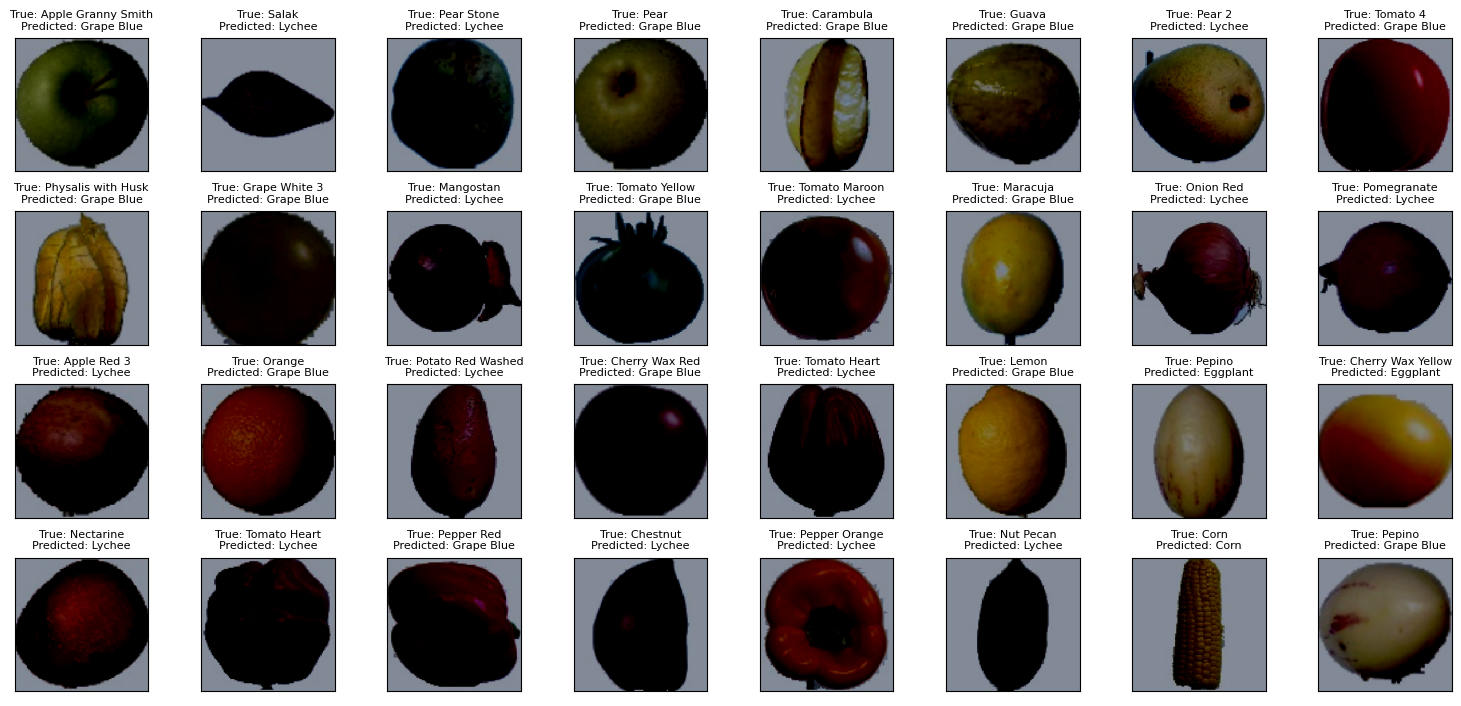

In [32]:
# Plotting a sample of images with predicted and true labels

# Setting the preprocessing_function to None to observe not tranformed photos
test_datagen.preprocessing_function = None
X_sample, y_sample = test_gen.next()

# Appling preprocessing on the sample anyway to obtain good result
predictions_resnet50_trimmed = trimmed_resnet50_model.predict(resnet_preprocess(X_sample), verbose=0)


fig, axes = plt.subplots(4, 8, figsize=(15, 7), subplot_kw={'xticks' : [], 'yticks' : []})

for i, ax in enumerate(axes.flat):
    ax.imshow(X_sample[i]/255.)
    ax.set_title(f'True: {label_list[np.argmax(y_sample[i])]}\nPredicted: {label_list[np.argmax(predictions_resnet50_trimmed[i])]}', fontsize=8)
    
plt.tight_layout(pad=0.5)
plt.show()

### Pruning the obtained model

In [33]:
epochs_pruning=2
n_train_images = len(train_df)

# computing total number of batches
end_step = np.ceil(n_train_images/batch_size).astype(np.int32) * epochs_pruning

# setting pruning schedule
# strong prunning- 90% final sparsity
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.6,
                                                               final_sparsity=0.9,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_pruning = tfmot.sparsity.keras.prune_low_magnitude(trimmed_resnet50_model, **pruning_params)

model_pruning.compile(optimizer="adam",
                          loss='categorical_crossentropy', 
                          metrics=["accuracy"])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [34]:
prun_log_dir = './logs/PrunedResNet50'

callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=prun_log_dir)
]

model_pruning.fit(train_gen, epochs=epochs_pruning, validation_data=validation_gen,
                      callbacks=callbacks)

Epoch 1/2
 112/1694 [>.............................] - ETA: 19:34 - loss: 4.4297 - accuracy: 0.0773

KeyboardInterrupt: 

In [35]:
# Model for pruning evaluation
loss_pruning_model, acc_pruning_model = model_pruning.evaluate(test_gen)

  4/709 [..............................] - ETA: 7:44 - loss: 4.7301 - accuracy: 0.0469

KeyboardInterrupt: 

In [36]:
pruned_model_comparasing_df = pd.DataFrame([[loss_pruning_model, loss_main_model],[acc_pruning_model, acc_main_model]],
                                          columns=["Model for prunning", "Main model"], 
                                           index=["Loss", "Accuracy"])

NameError: name 'loss_pruning_model' is not defined

## Classifications on multiple fruits

In [37]:
multi_class_dir = os.path.join(base_dir, 'test-multiple_fruits')

In [38]:
# getting all files name and sorting them alphabeticly (as they are showed in the file explorator)
filenames = [filename for filename in os.listdir(multi_class_dir)]
filenames.sort(key=lambda x: x.lower())

In [39]:
multiclass_df = pd.DataFrame(filenames, columns=['filename'])

In [40]:
# funtion to convert multiple-fruit image filename into labels
def extract_label(filename: str):
    without_extension = re.sub('.jpg', '', filename)
    removed_numbers = re.sub('\d+', '', without_extension)
    removed_bracets = re.sub(r'\([^)]*\)', '', removed_numbers)

    labels = removed_bracets.split('_')
    
    return labels 

In [41]:
multiclass_df['labels'] = multiclass_df.filename.apply(extract_label)

In [42]:
multiclass_df.head()

,filename,labels
0,apple.jpg,[apple]
1,apple_apricot_nectarine_peach_peach(flat)_pome...,"[apple, apricot, nectarine, peach, peach, pome..."
2,apple_apricot_peach_peach(flat)_pomegranate_pe...,"[apple, apricot, peach, peach, pomegranate, pe..."
3,apple_apricot_peach_peach(flat)_pomegranate_pe...,"[apple, apricot, peach, peach, pomegranate, pe..."
4,apple_apricot_peach_peach(flat)_pomegranate_pe...,"[apple, apricot, peach, peach, pomegranate, pe..."


In [43]:
multi_test_gen = test_datagen.flow_from_dataframe(
    multiclass_df,
    directory=multi_class_dir,
    x_col="filename",
    y_col="labels",
    target_size=image_size[:-1],
    batch_size=1,
    class_mode='categorical',
    # to keep alphadical 
    shuffle=False)

Found 103 validated image filenames belonging to 40 classes.


In [44]:
# it wasn't set in the ImageDataGenerator constructor
train_datagen.preprocessing_function = resnet_preprocess
test_datagen.preprocessing_function = resnet_preprocess

In [45]:
# loading not prepocessed images to display them lateron
not_preprocessed_images = [plt.imread(os.path.join(multi_class_dir, filename)) for filename in filenames]

### Single-label classification

In [46]:
# Single label model prediction
single_label_predict = trimmed_resnet50_model.predict(multi_test_gen)

103/103 [==============================] - 11s 100ms/step


In [47]:
# Getting label names
predicted_single_labels = [label_list[np.argmax(pred)] for pred in single_label_predict]

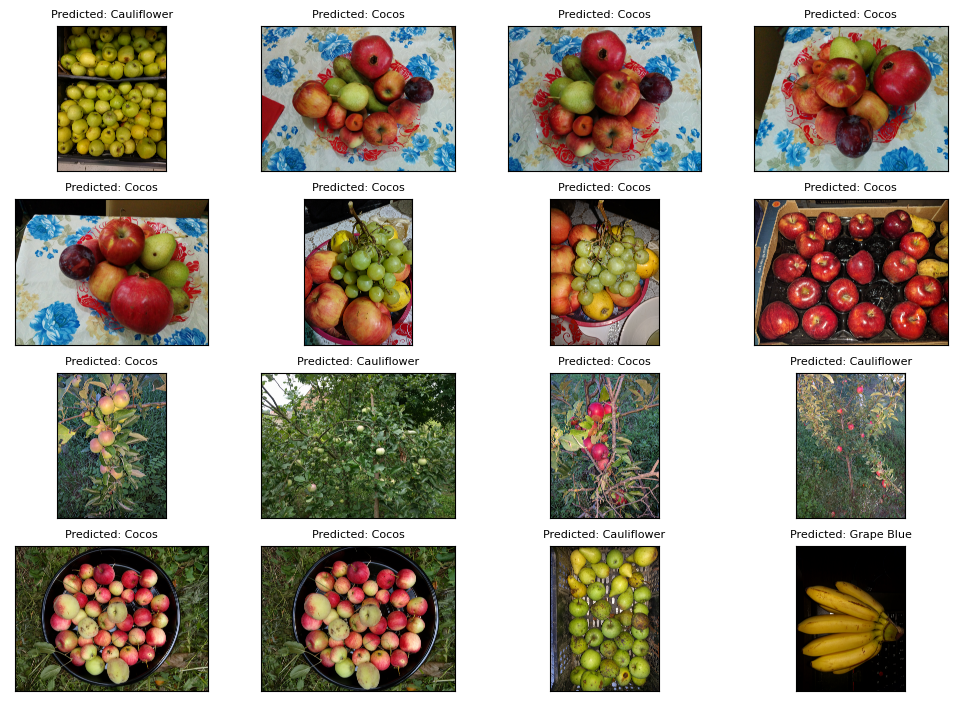

In [69]:
# only manual analysis since we use single label model to multilabel task
fig, axes = plt.subplots(4, 4, figsize=(10, 7), subplot_kw={'xticks' : [], 'yticks' : []})

for i, ax in enumerate(axes.flat):
    ax.imshow(not_preprocessed_images[i]/255.)
    ax.set_title(f'Predicted: {predicted_single_labels[i]}', fontsize=8)
    
plt.tight_layout(pad=0.5)
plt.show()

### Multi-label classification
Single label was not a successful attempt, so the idea is to train a model on given dataset as it was multilabel task. Letting it to assign probabilty independly.

#### Creating the model

In [49]:
# Model to preform multi-label classification
# Two layers same us before
avg_pooling = GlobalAveragePooling2D()(pretrained_resnet50.get_layer('conv2_block3_out').output)
dense = Dense(256, activation='relu')(avg_pooling)

# since it is multiclassification instead of softmax we have sigmoid
# instead of computing probability with sums to 100% for all classes
# it is calculated for each class separetly
output_layer = Dense(num_classes, activation='sigmoid', name='output_layer')(dense)

multi_label_model = Model(inputs=pretrained_resnet50.input, outputs=output_layer)

In [50]:
# binary_crossentropy because we treat multi-label classfication 
# as multiple binary classifications
multi_label_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [51]:
log_dir = "logs/ResNet50-multilabel/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [52]:
multi_label_model.fit(train_gen, validation_data=validation_gen, epochs=8, 
                       callbacks=[tensorboard_callback])

Epoch 1/8
   2/1694 [..............................] - ETA: 19:29 - loss: 0.7125 - acc: 0.0000e+00  

KeyboardInterrupt: 

In [53]:
multi_label_model.save('multi-label-model.h5')

In [54]:
loss_multi_label_model, acc_multi_label_model = multi_label_model.evaluate(test_gen)

  4/709 [..............................] - ETA: 7:46 - loss: 0.4317 - acc: 0.0234   

KeyboardInterrupt: 

#### Predicting on the multi label model

In [59]:
multi_label_model = load_model('multi-label-model.h5')

In [56]:
predicted_multi_labels = multi_label_model.predict(multi_test_gen)

103/103 [==============================] - 12s 103ms/step


In [60]:
# function which for the single output gives fruits with n_top probabilties
def get_top_fruit_probality(predicted_logits, n_top=3):
    sorted_args = np.argsort(predicted_logits)[-n_top:]
    
    fruit_probality = {}
    
    for arg in sorted_args:
        fruit_probality[label_list[arg]] = predicted_logits[arg]
        
    return fruit_probality

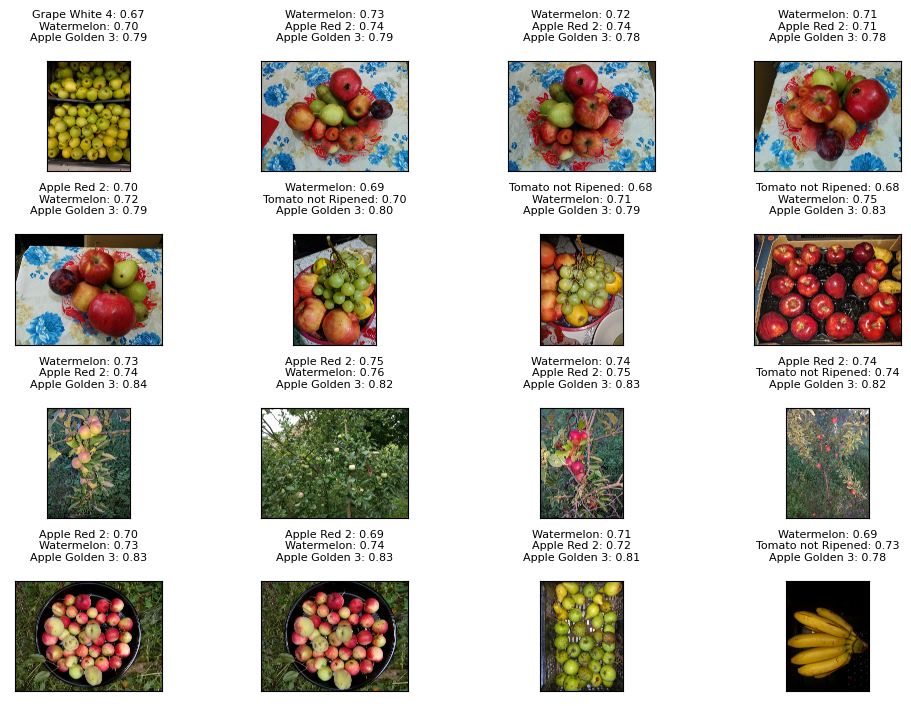

In [72]:
fig, axes = plt.subplots(4, 4, figsize=(10, 7), subplot_kw={'xticks' : [], 'yticks' : []})

for i, ax in enumerate(axes.flat):
    ax.imshow(not_preprocessed_images[i]/255.)
    
    # creating a fancy title
    title = ""
    for fruit, prob in get_top_fruit_probality(predicted_multi_labels[i]).items():
        title += fruit + ": " + "{:.2f}".format(prob) + "\n"
        
    ax.set_title(title, fontsize=8)
    
plt.tight_layout(pad=0.5)
plt.show()